In [4]:
!pip install torch_geometric torch_optimizer

In [6]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import SNRAdam
from SNRAdam import SNRAdam
import torch_optimizer as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())

# Check the dataset
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')


Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


In [8]:
data = dataset[0]

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
Is undirected: True


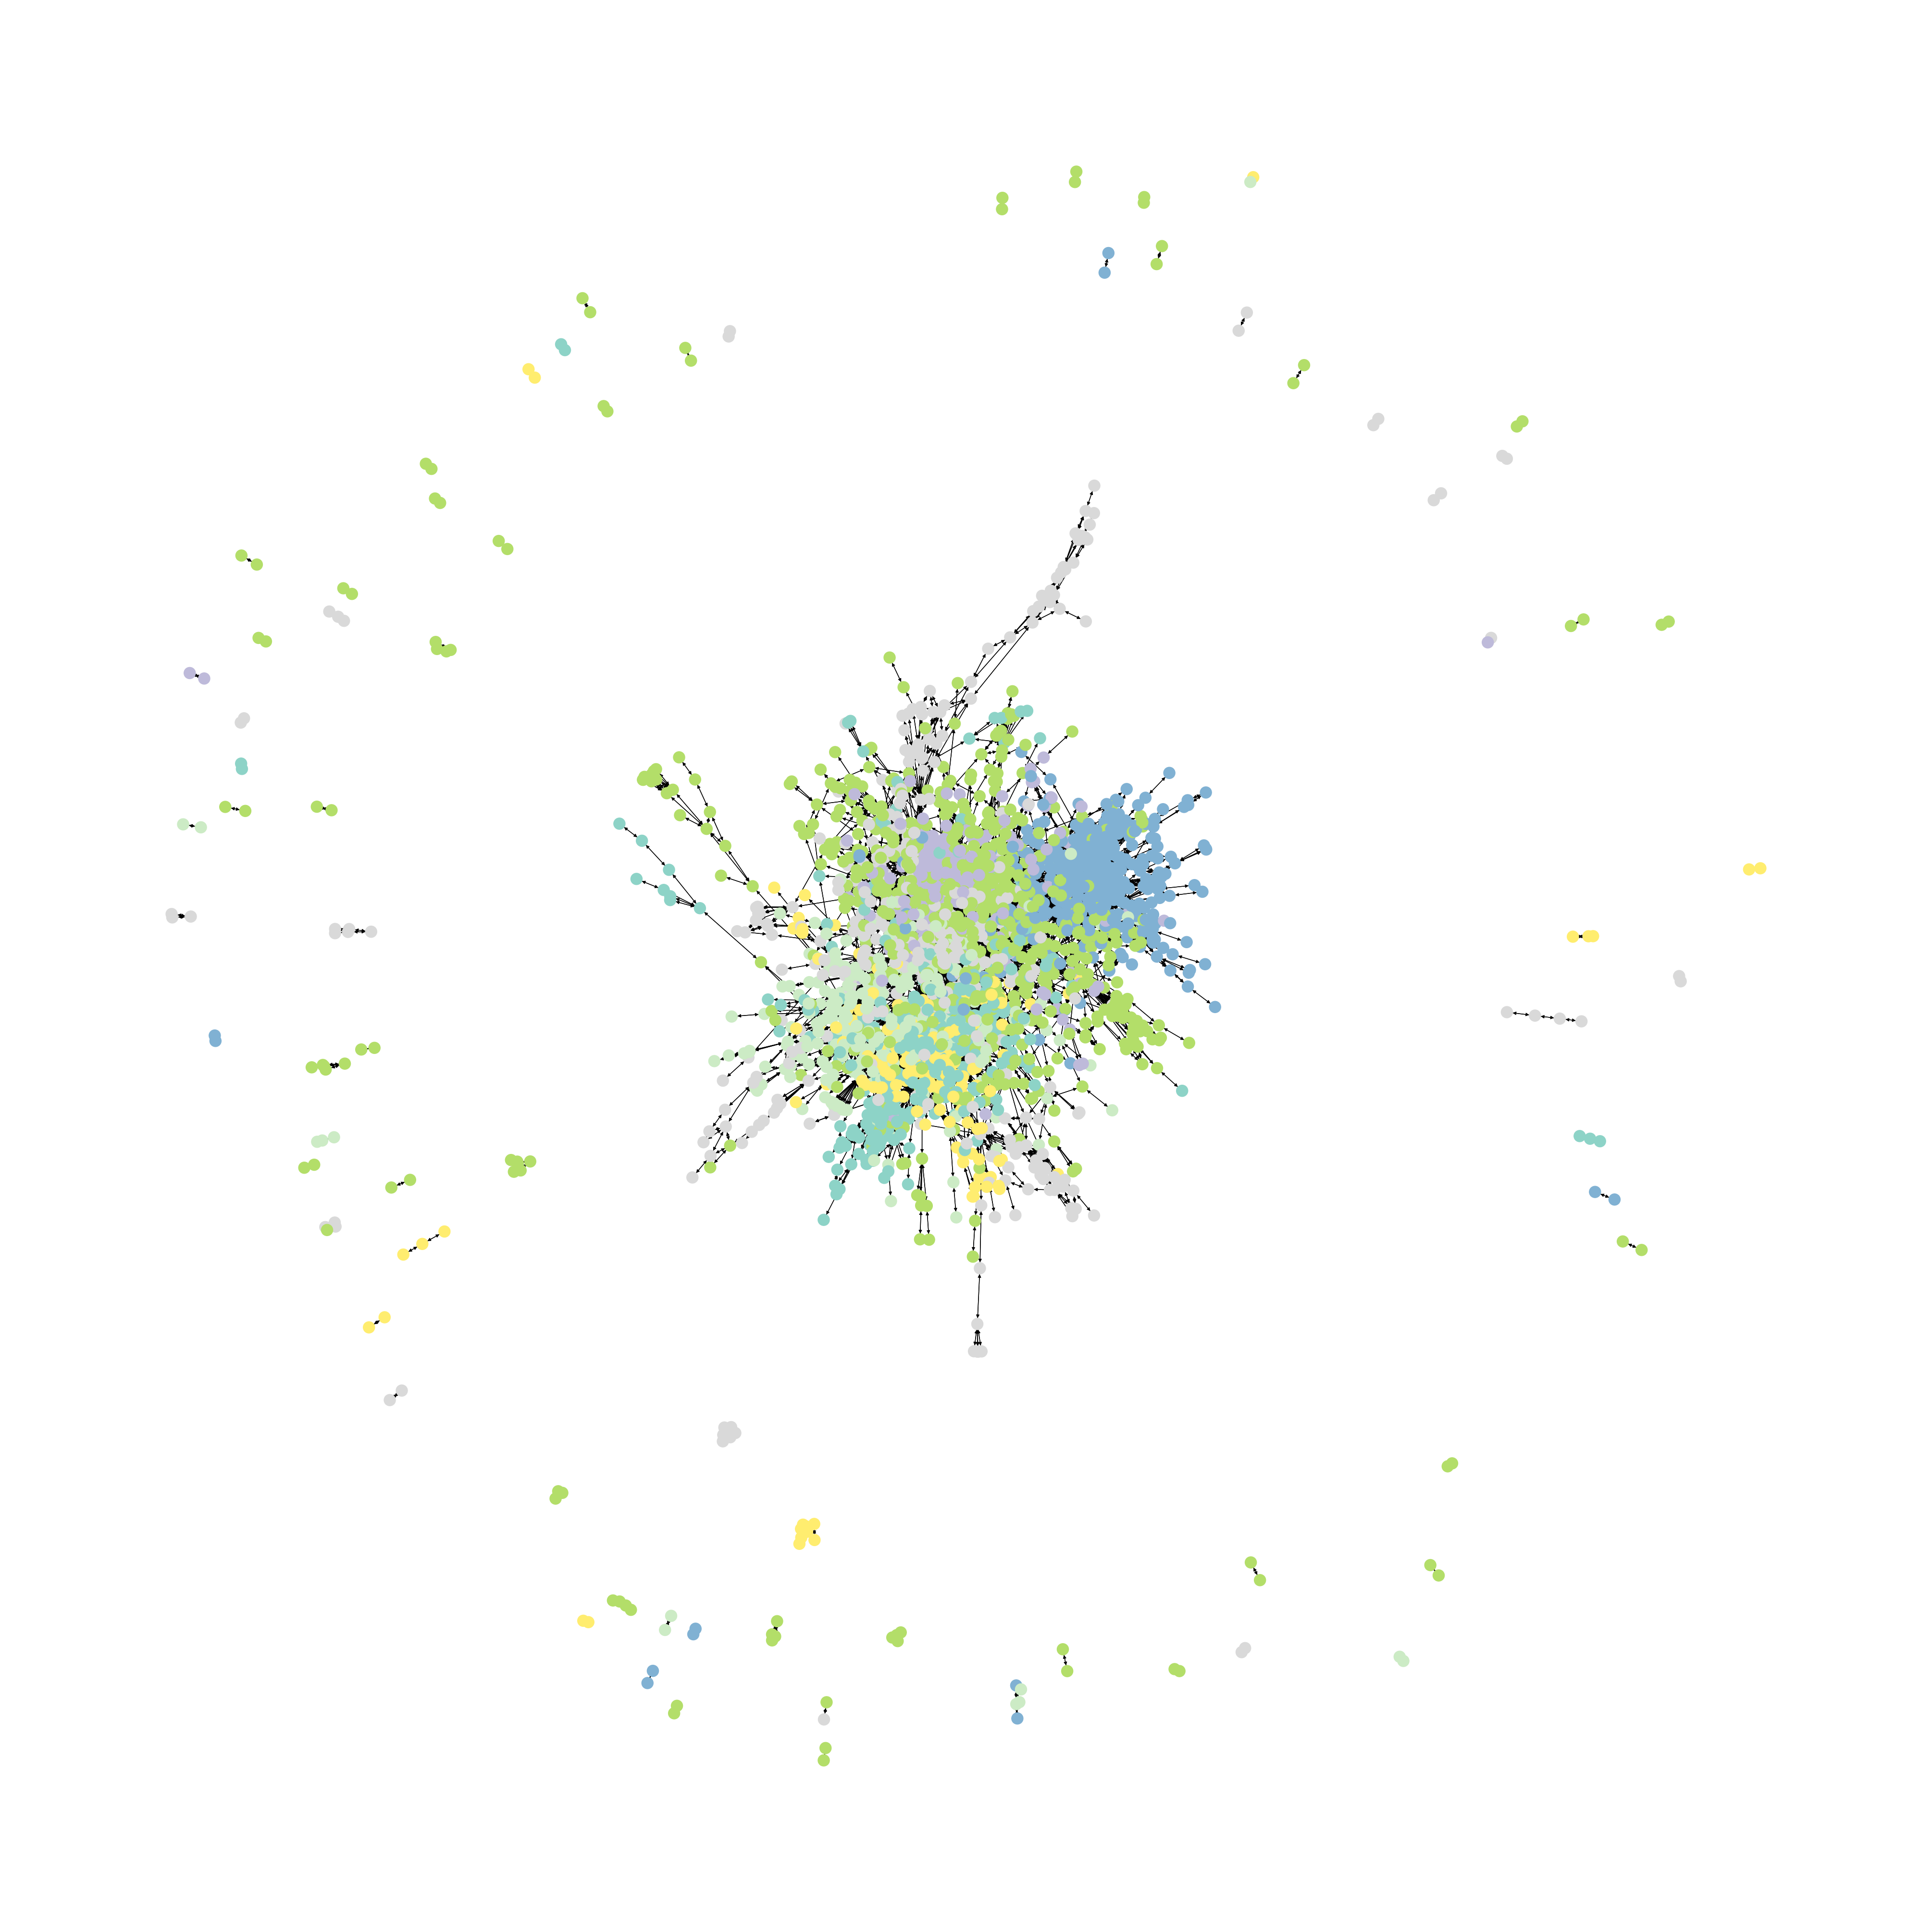

In [6]:
data = dataset[0]
G = to_networkx(data, node_attrs=['x'], edge_attrs=None)

plt.figure(figsize=(40, 40))
nx.draw(G, with_labels=False, node_color=data.y, cmap=plt.get_cmap('Set3'))
plt.show()

#GCN

In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, 16)
        self.conv4 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN()
print(model)


GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 16)
  (conv4): GCNConv(16, 7)
)


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

In [21]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')

def train_model(model, criterion, optimizer, data, num_epochs=200, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

            _, train_pred = out.max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())
            train_accuracies.append(train_acc)

            _, val_pred = out.max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())
            val_accuracies.append(val_acc)

            _, test_pred = out.max(dim=1)
            test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            test_acc = test_correct / int(data.test_mask.sum().item())
            test_accuracies.append(test_acc)

            print(f'Epoch {epoch}/{num_epochs - 1}, '
                  f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model)
                if early_stopping.early_stop:
                    print(f'Early stopping at epoch {epoch}')
                    break

    if early_stopping:
        model.load_state_dict(torch.load('checkpoint.pt'))
    return model, train_accuracies, val_accuracies, test_accuracies

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = correct / int(data.train_mask.sum())

    correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = correct / int(data.val_mask.sum())

    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = correct / int(data.test_mask.sum())

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam' : SNRAdam(model.parameters(), lr=0.01)
}

In [22]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GCNConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 1/199, Training Accuracy: 0.2357, Validation Accuracy: 0.3560
Epoch 2/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3180
Epoch 3/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3180
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 7/199, Training Accuracy: 0.2571, Validation Accuracy: 0.3800
Epoch 8/199, Training Accuracy: 0.2286, Validation Accuracy: 0.3500
Epoch 9/199, Training Accuracy: 0.2786, Validation Accuracy: 0.3540
Epoch 10/199, Training Accuracy: 0.2714, Validation Accuracy: 0.3960
Epoch 11/199, Training Accuracy: 0.2357, Validation Accuracy: 0.3720
Epoch 12/199, Training Accuracy: 0.2571, Validation Accuracy: 0.

KeyboardInterrupt: 

In [ ]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

In [ ]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_test_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

In [ ]:
# Extract final accuracies

max_train_accuracies = {name: max(accuracies) for name, accuracies in all_train_accuracies.items()}
max_test_accuracies = {name: max(accuracies) for name, accuracies in all_test_accuracies.items()}

# Convert to lists for plotting
optimizers_list = list(max_train_accuracies.keys())
optimizers_test_list = list(max_test_accuracies.keys())
train_values = [max_train_accuracies[name] for name in optimizers_list]
test_values = [max_test_accuracies[name] for name in optimizers_test_list]

bar_width = 0.35
x = np.arange(len(optimizers_list))

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_values, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_values, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#GAT

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import pandas as pd

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset.num_node_features, 128, heads=16, dropout=0.3)
        self.conv2 = GATConv(128 * 16, 64, heads=8, dropout=0.3)
        self.conv3 = GATConv(64 * 8, 16, heads=4, dropout=0.3)
        self.conv4 = GATConv(16 * 4, dataset.num_classes, heads=1, concat=False, dropout=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GAT()
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model, epoch):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model = model.state_dict()
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping at epoch {epoch}")

    def load_best_model(self, model):
        model.load_state_dict(self.best_model)

def train_model(model, criterion, optimizer, data, num_epochs=200, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            _, train_pred = model(data).max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())
            train_accuracies.append(train_acc)

            _, val_pred = model(data).max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())
            val_accuracies.append(val_acc)

            _, test_pred = out.max(dim=1)
            test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            test_acc = test_correct / int(data.test_mask.sum().item())
            test_accuracies.append(test_acc)

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            print(f'Epoch {epoch}/{num_epochs - 1}, '
                   f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model, epoch)
                if early_stopping.early_stop:
                    early_stopping.load_best_model(model)
                    break

    return model, train_accuracies, val_accuracies, test_accuracies

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = correct / int(data.train_mask.sum())

    correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = correct / int(data.val_mask.sum())

    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = correct / int(data.test_mask.sum())

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam' : SNRAdam(model.parameters(), lr=0.01)
}

GAT(
  (conv1): GATConv(1433, 128, heads=16)
  (conv2): GATConv(2048, 64, heads=8)
  (conv3): GATConv(512, 16, heads=4)
  (conv4): GATConv(64, 7, heads=1)
)


In [17]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GCNConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.2357, Validation Accuracy: 0.1520
Epoch 1/199, Training Accuracy: 0.2357, Validation Accuracy: 0.1520
Epoch 2/199, Training Accuracy: 0.2000, Validation Accuracy: 0.1720
Epoch 3/199, Training Accuracy: 0.1786, Validation Accuracy: 0.1700
Epoch 4/199, Training Accuracy: 0.2000, Validation Accuracy: 0.1860
Epoch 5/199, Training Accuracy: 0.2357, Validation Accuracy: 0.1780
Epoch 6/199, Training Accuracy: 0.2286, Validation Accuracy: 0.2040
Epoch 7/199, Training Accuracy: 0.2143, Validation Accuracy: 0.1860
Epoch 8/199, Training Accuracy: 0.2071, Validation Accuracy: 0.1680
Epoch 9/199, Training Accuracy: 0.2071, Validation Accuracy: 0.1860
Epoch 10/199, Training Accuracy: 0.2643, Validation Accuracy: 0.1940
Epoch 11/199, Training Accuracy: 0.2286, Validation Accuracy: 0.1860
Epoch 12/199, Training Accuracy: 0.2429, Validation Accuracy: 0.

NameError: name 'test_acc' is not defined

In [ ]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

In [ ]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_test_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

In [ ]:
# Extract final accuracies

max_train_accuracies = {name: max(accuracies) for name, accuracies in all_train_accuracies.items()}
max_test_accuracies = {name: max(accuracies) for name, accuracies in all_test_accuracies.items()}

# Convert to lists for plotting
optimizers_list = list(max_train_accuracies.keys())
optimizers_test_list = list(max_test_accuracies.keys())
train_values = [max_test_accuracies[name] for name in optimizers_list]
test_values = [max_test_accuracies[name] for name in optimizers_test_list]

bar_width = 0.35
x = np.arange(len(optimizers_list))

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_values, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_values, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#GraphSAGE

In [9]:
# https://arxiv.org/abs/1706.02216
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.conv3 = SAGEConv(64, 16)
        self.conv4 = SAGEConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE()
print(model)

GraphSAGE(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (conv2): SAGEConv(128, 64, aggr=mean)
  (conv3): SAGEConv(64, 16, aggr=mean)
  (conv4): SAGEConv(16, 7, aggr=mean)
)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import pandas as pd

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.conv3 = SAGEConv(64, 16)
        self.conv4 = SAGEConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE()
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model, epoch):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model = model.state_dict()
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping at epoch {epoch}")

    def load_best_model(self, model):
        model.load_state_dict(self.best_model)

def train_model(model, criterion, optimizer, data, num_epochs=200, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            _, train_pred = model(data).max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())
            train_accuracies.append(train_acc)

            _, val_pred = model(data).max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())
            val_accuracies.append(val_acc)

            _, test_pred = out.max(dim=1)
            test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            test_acc = test_correct / int(data.test_mask.sum().item())
            test_accuracies.append(test_acc)

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            print(f'Epoch {epoch}/{num_epochs - 1}, '
                   f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model, epoch)
                if early_stopping.early_stop:
                    early_stopping.load_best_model(model)
                    break

    return model, train_accuracies, val_accuracies, test_accuracies

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = correct / int(data.train_mask.sum())

    correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = correct / int(data.val_mask.sum())

    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = correct / int(data.test_mask.sum())
    test_accuracies.append(test_acc)

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam' : SNRAdam(model.parameters(), lr=0.01)
}

GraphSAGE(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (conv2): SAGEConv(128, 64, aggr=mean)
  (conv3): SAGEConv(64, 16, aggr=mean)
  (conv4): SAGEConv(16, 7, aggr=mean)
)


In [11]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GCNConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------


NameError: name 'GCNConv' is not defined

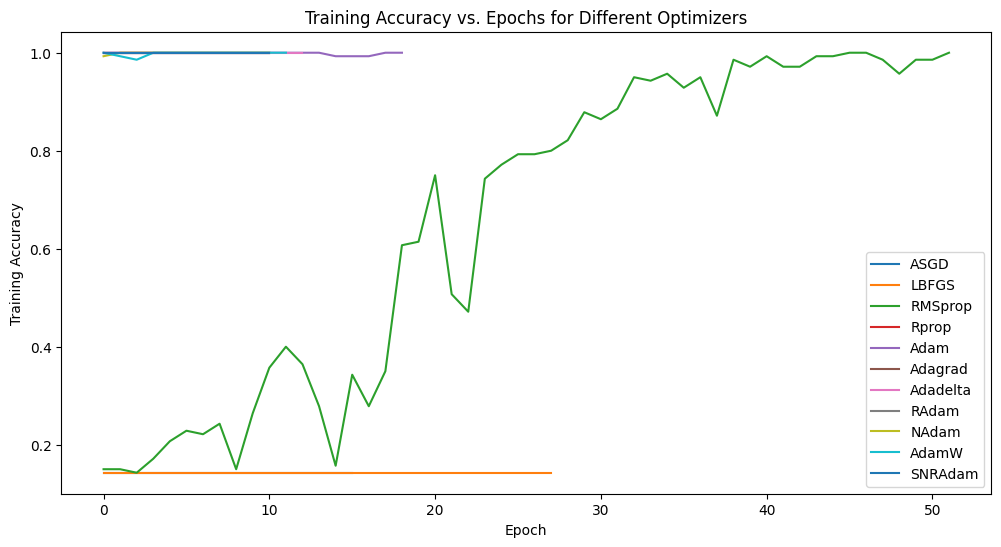

In [85]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

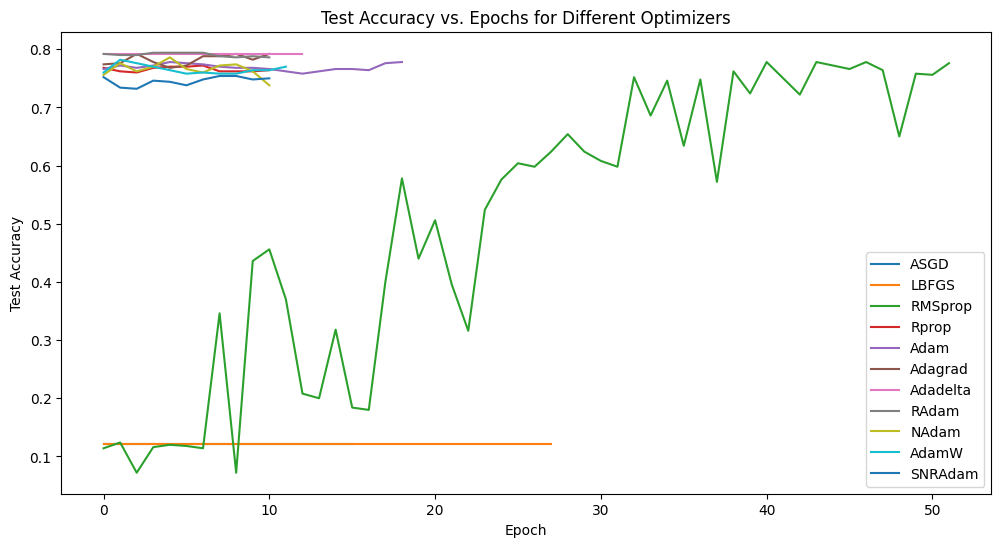

In [86]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_test_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

{'ASGD': 0.14285714285714285, 'LBFGS': 0.14285714285714285, 'RMSprop': 1.0, 'Rprop': 1.0, 'Adam': 1.0, 'Adagrad': 1.0, 'Adadelta': 1.0, 'RAdam': 1.0, 'NAdam': 1.0, 'AdamW': 1.0, 'SNRAdam': 1.0}


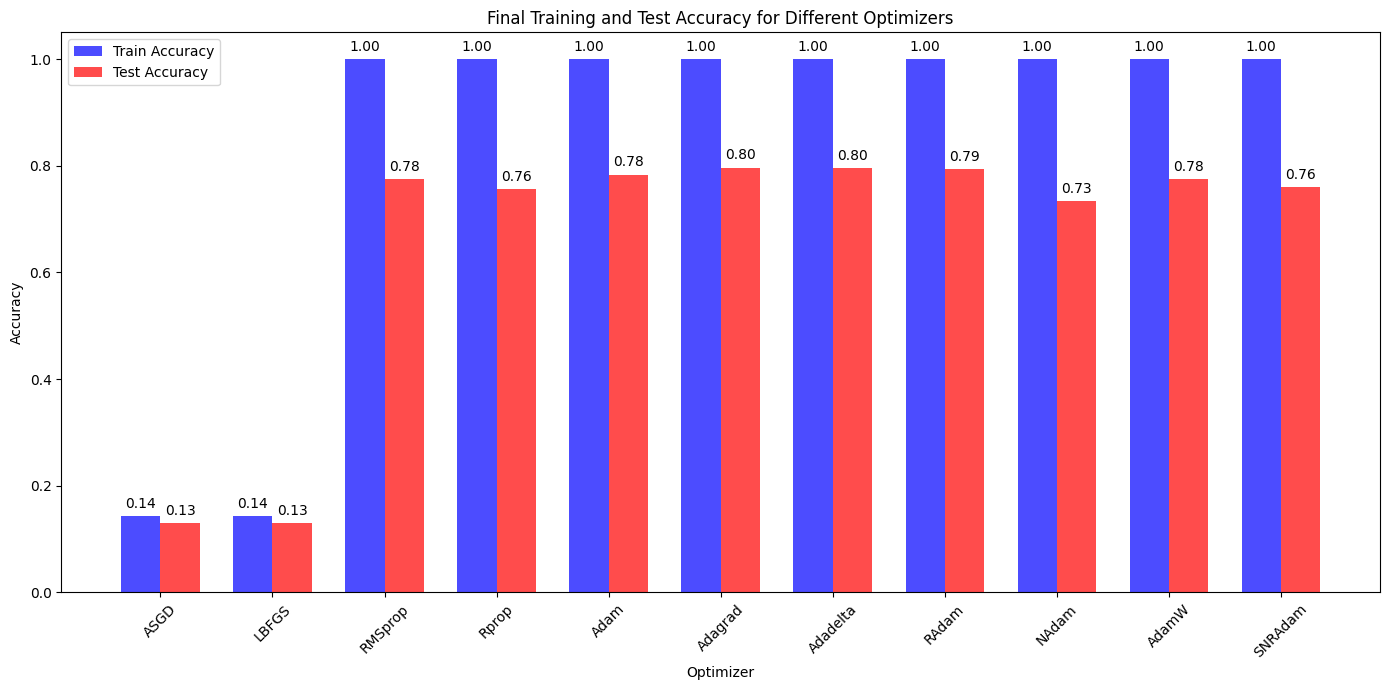

In [87]:
# Extract final accuracies

max_train_accuracies = {name: max(accuracies) for name, accuracies in all_train_accuracies.items()}
max_test_accuracies = {name: max(accuracies) for name, accuracies in all_test_accuracies.items()}

# Convert to lists for plotting
optimizers_list = list(max_train_accuracies.keys())
optimizers_test_list = list(max_test_accuracies.keys())
train_values = [max_test_accuracies[name] for name in optimizers_list]
test_values = [max_test_accuracies[name] for name in optimizers_test_list]

bar_width = 0.35
x = np.arange(len(optimizers_list))

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_values, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_values, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#GAE

In [88]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE
import torch.nn as nn
import torch.optim as optim

class GCNEncoder(torch.nn.Module):
    def __init__(self):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 32, cached=True)
        self.conv2 = GCNConv(32, 16, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2(x, edge_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_channels = 16
num_features = dataset.num_features

model = GAE(GCNEncoder()).to(device)
x = data.x.to(device)
edge_index = data.edge_index.to(device)
criterion = nn.CrossEntropyLoss()

# Define the NodeClassifier
class NodeClassifier(nn.Module):
    def __init__(self):
        super(NodeClassifier, self).__init__()
        self.linear = nn.Linear(16, dataset.num_classes)

    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=1)

classifier = NodeClassifier().to(device)
criterion = nn.CrossEntropyLoss()
labels = data.y.to(device)
train_mask = data.train_mask.to(device)
val_mask = data.val_mask.to(device)
test_mask = data.test_mask.to(device)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, edge_index)
    loss = model.recon_loss(z, edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)

def evaluate_model(embeddings, mask):
    classifier.eval()
    with torch.no_grad():
        out = classifier(embeddings)
        pred = out[mask].max(1)[1]
        acc = pred.eq(labels[mask]).sum().item() / mask.sum().item()
    return acc

def train_classifier():
    classifier.train()
    optimizer.zero_grad()
    out = classifier(embeddings)
    loss = criterion(out[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test_classifier(mask):
    classifier.eval()
    with torch.no_grad():
        out = classifier(embeddings)
        pred = out[mask].max(1)[1]
        acc = pred.eq(labels[mask]).sum().item() / mask.sum().item()
    return acc

def train_model(model, criterion, optimizer, data, num_epochs=25, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        z = model.encode(data.x.to(device), data.edge_index.to(device))
        loss = model.recon_loss(z, data.edge_index.to(device))
        loss.backward()

        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                z = model.encode(data.x.to(device), data.edge_index.to(device))
                loss = model.recon_loss(z, data.edge_index.to(device))
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        embeddings = model.encode(data.x.to(device), data.edge_index.to(device)).detach()
        train_acc = evaluate_model(embeddings, data.train_mask)
        val_acc = evaluate_model(embeddings, data.val_mask)
        test_acc = evaluate_model(embeddings, data.test_mask)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch}/{num_epochs - 1}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

        if early_stopping:
            early_stopping(val_acc, model, epoch)
            if early_stopping.early_stop:
                early_stopping.load_best_model(model)
                break

    return model, train_accuracies, val_accuracies, test_accuracies

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=25, patience=10):

    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    embeddings = model.encode(data.x.to(device), data.edge_index.to(device)).detach()
    train_acc = evaluate_model(embeddings, data.train_mask)
    val_acc = evaluate_model(embeddings, data.val_mask)
    test_acc = evaluate_model(embeddings, data.test_mask)

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies

# Different optimizers
lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam': SNRAdam(model.parameters(), lr=lr)
}

In [89]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GCNConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0920
Epoch 1/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0920
Epoch 2/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0920
Epoch 3/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0920
Epoch 4/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0920
Epoch 5/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0920
Epoch 6/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0920
Epoch 7/199, Training Accuracy: 0.1714, Validation Accuracy: 0.0920
Epoch 8/199, Training Accuracy: 0.1714, Validation Accuracy: 0.0940
Epoch 9/199, Training Accuracy: 0.1714, Validation Accuracy: 0.0920
Epoch 10/199, Training Accuracy: 0.1714, Validation Accuracy: 0.0920
Early stopping at epoch 10
Train Accuracy: 0.1714, Validation Accuracy: 0.0920, Test Accuracy: 0.1090
-------------------------------

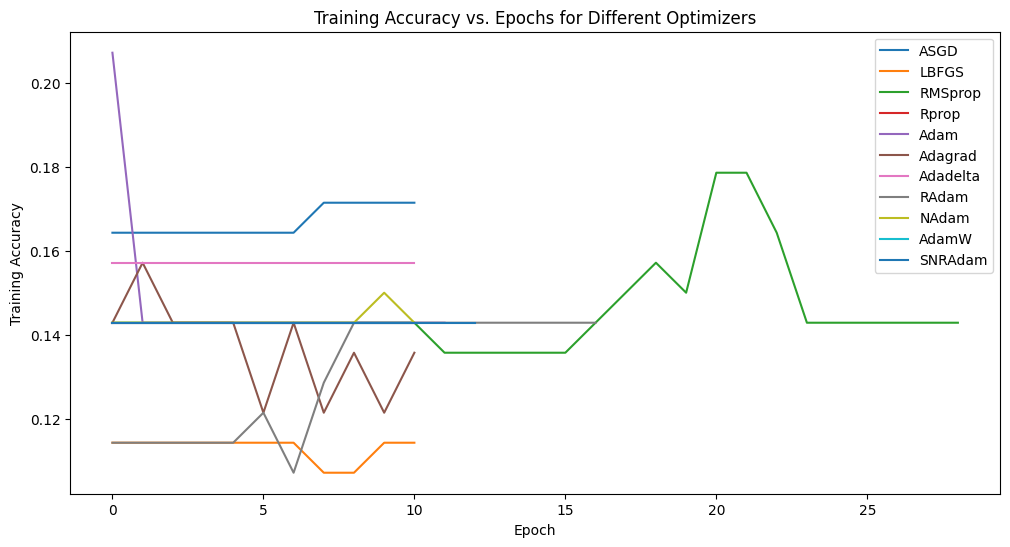

In [90]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

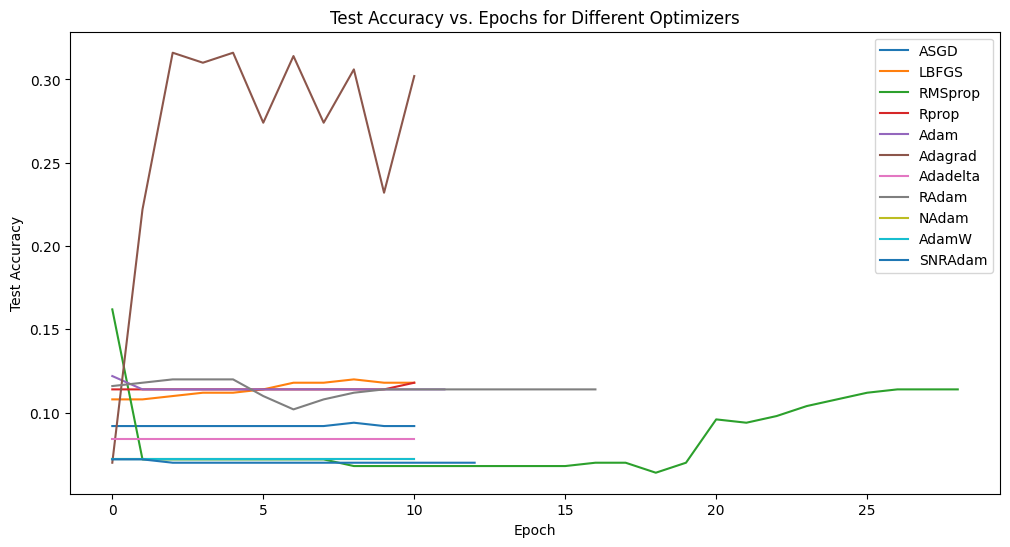

In [91]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_val_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

{'ASGD': 0.17142857142857143, 'LBFGS': 0.11428571428571428, 'RMSprop': 0.14285714285714285, 'Rprop': 0.14285714285714285, 'Adam': 0.14285714285714285, 'Adagrad': 0.1357142857142857, 'Adadelta': 0.15714285714285714, 'RAdam': 0.14285714285714285, 'NAdam': 0.14285714285714285, 'AdamW': 0.14285714285714285, 'SNRAdam': 0.14285714285714285}


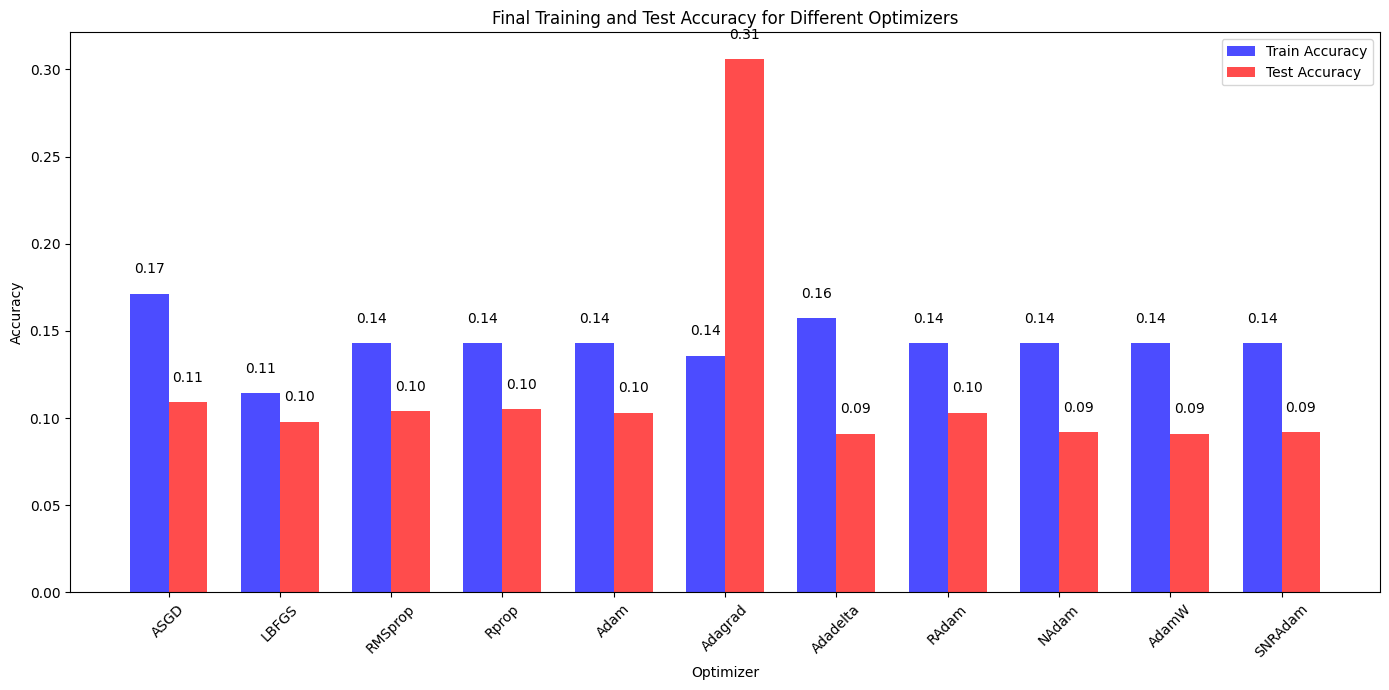

In [92]:
# Extract final accuracies

max_train_accuracies = {name: max(accuracies) for name, accuracies in all_train_accuracies.items()}
max_test_accuracies = {name: max(accuracies) for name, accuracies in all_test_accuracies.items()}

# Convert to lists for plotting
optimizers_list = list(max_train_accuracies.keys())
optimizers_test_list = list(max_test_accuracies.keys())
train_values = [max_test_accuracies[name] for name in optimizers_list]
test_values = [max_test_accuracies[name] for name in optimizers_test_list]

bar_width = 0.35
x = np.arange(len(optimizers_list))

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_values, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_values, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()